# Basic logic of comparing text similarity using text embedding

1. The first step is using text embedding vecotr to represent texts
2. The second step is using consine similarity to measure the similarity between input texts and recommended texts
3. The thirs step is normalizting the consine similairty scores into the range of 0-100

I use Bert and Doc2vec to do the text embedding

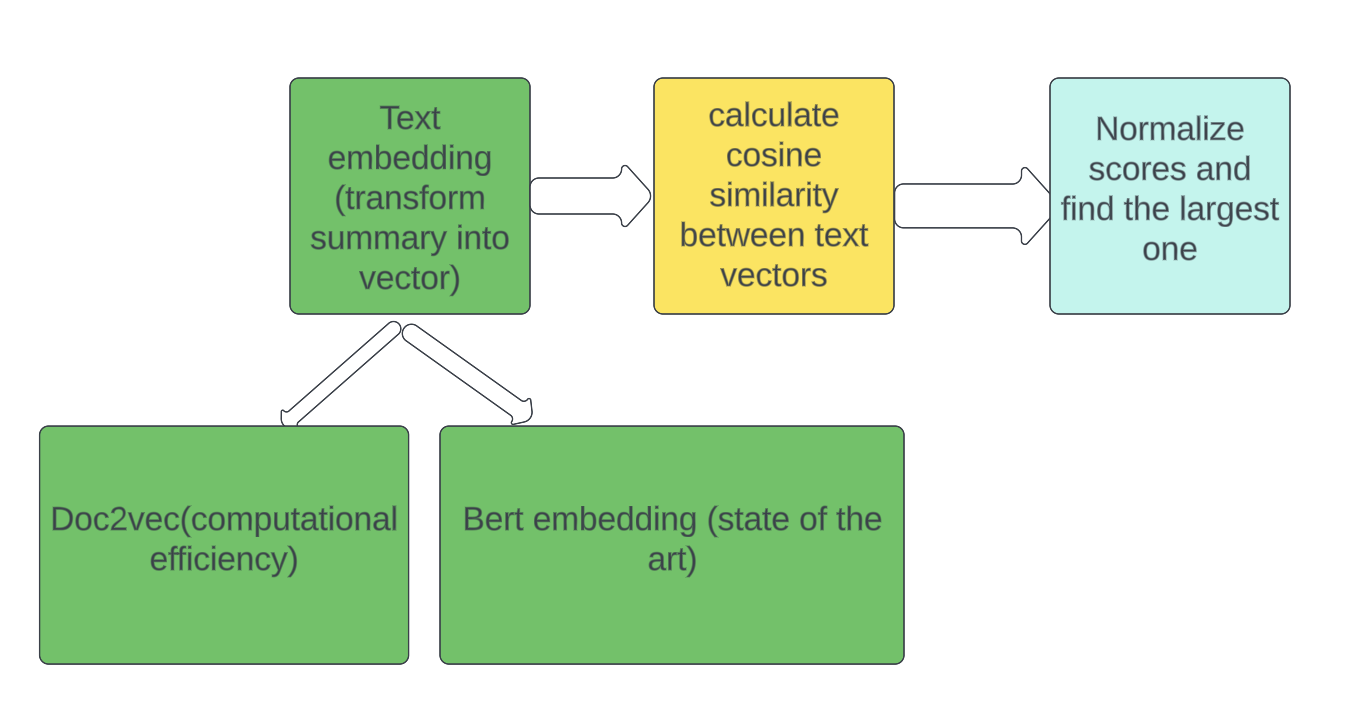

## BERT Embeddings Example (using transformers library):

In [2]:
from transformers import BertTokenizer, BertModel
import torch
import torch.nn.functional
import numpy as np
import math
import copy


In [69]:
class Berttextsimilarity(): 
    
    '''
    inputtextsummary is summary of the input text, and it is a string
    recommendtextsummary is the dictionary containing the titles of the recommended papers and their summary
    recommendtextsummary is in the form : {"title1":"summary1","title2":'summary2'...}
    '''

    # Constructor method (called when an instance is created)
    def __init__(self, inputtextsummary,recommendtextsummary):
        self.inputtextsummary=inputtextsummary
        self.recommendtextsummary=recommendtextsummary
        self.recommendsummarylist=list(self.recommendtextsummary.values()) #get the list of the summary of the recommended papaers
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") # first use bert tokenizer to tokenize the summary
        self.bert= BertModel.from_pretrained("bert-base-uncased") # import bert model

    # transform original text summary into bert pooler output, return a text embedding 
    def originaltextbertembedding(self): 
        inputtexttoken = self.tokenizer.encode(self.inputtextsummary, return_tensors="pt") 
        with torch.no_grad():
            inputtextembedding = self.bert(inputtexttoken).pooler_output
        return inputtextembedding
    
    # transform recommend text summary into bert pooler output, return a list of text embeddings
    def recommendtextbertembedding(self):
        recommendembeddinglist=[] # the list of the embedding of the recommended papers
        for summary in self.recommendsummarylist:
            recommendtexttoken = self.tokenizer.encode(summary, return_tensors="pt") 
            with torch.no_grad():
                recommendtextembedding = self.bert(recommendtexttoken).pooler_output
                recommendembeddinglist.append(recommendtextembedding)
        return recommendembeddinglist
    
    #calculate the cosine similarity between embedding of the input text and embeddings of the recommended text, returhn a list
    def cosinesimilarity(self):
        originaltextbertembedding=self.originaltextbertembedding()
        recommendembeddinglist= self.recommendtextbertembedding()
        cosinessimilaritylist=[] #store the consine similarity value 
        for embedding in recommendembeddinglist:
            cosinessimilaritylist.append( torch.nn.functional.cosine_similarity(originaltextbertembedding, embedding) )
        return cosinessimilaritylist
    
    #softmax the cosine similarity, the return is the dictionary containing the recommended text title and their corresponding similairity score
    def normalizesimilarityscore(self):
        cosinessimilaritylist=self.cosinesimilarity()
        cosinessimilaritylist=[float (score) for score in cosinessimilaritylist] #transform the tensor into integer
        maxscore=max(cosinessimilaritylist) #maixmum score
        minscore=min(cosinessimilaritylist) #minmum score
        normalized_scores = [(value - minscore) / (maxscore - minscore) * 100 for value in cosinessimilaritylist] #normalize the score to range 0-100
        recommendtextsimilarity=recommendtextsummary.copy()
        for key, new_value in zip(recommendtextsimilarity, normalized_scores ): #assign similarity score to each recommend text
            recommendtextsimilarity[key] = np.round(new_value,2)
        # Find the most similar text
        most_similar_book, _ = max(recommendtextsimilarity.items(), key=lambda x: x[1])
        print(f'the most correlated recommended text is {most_similar_book}')
        return recommendtextsimilarity,most_similar_book


In [77]:
inputtextsummary="this is the first class I have ever written in python"

recommendtextsummary={"exp1":"this is the first class I have ever written in java",
                      "exp2":"Python is very easy to use",
                      "exp3":"I love today's weather",
                      "exp4":"I love NLP",
                      "exp5":"NLP needs a lot of python coding",
                      "exp6":"I love China"}

In [80]:
bertexample=Berttextsimilarity(inputtextsummary,recommendtextsummary)
similar_socre, most_simialr_book=bertexample.normalizesimilarityscore()
print("text similar score :", similar_socre)
print(f'the most similar book is {most_simialr_book}')

the most correlated recommended text is exp1
text similar score : {'exp1': 100.0, 'exp2': 87.58, 'exp3': 0.0, 'exp4': 75.7, 'exp5': 91.15, 'exp6': 67.28}
the most similar book is exp1
